In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
df=pd.read_excel('Online Retail.xlsx')

date_column='InvoiceDate'
id_column='CustomerID'
start_date='2012-01-01'
freq='W-MON'

In [37]:
df=df.dropna(subset=['CustomerID'])
df[date_column]=pd.to_datetime(df[date_column]).dt.floor('d')

In [42]:
def cohort(input_df, date_column, id_column, start_date='1970-01-01', freq='MS', normalize=False):   
    df=input_df.copy()
    
    def cohort_period(df):
        df['CohortPeriod'] = np.arange(len(df)) + 1
        return df
        
    df['CohortGroup']=df.groupby([id_column])[date_column].transform(min)    
    df=df[df['CohortGroup'] >= start_date]

    df_grouped=df.groupby([pd.Grouper(key='CohortGroup',freq=freq, closed='left', label='left'),pd.Grouper(key=date_column,freq=freq, closed='left', label='left')])
    df=df_grouped[id_column].nunique().rename('id_nuniq').to_frame()
    
    df.reset_index(inplace=True)
    df=df.groupby('CohortGroup').apply(lambda row : row.resample(freq,on=date_column).sum().fillna(0))
    df=df.groupby('CohortGroup').apply(cohort_period)
    
    df.reset_index(inplace=True)    
    base_df=pd.DataFrame(index = pd.date_range(df['CohortGroup'].min(), df['CohortGroup'].max(), freq=freq, closed=None))
    df=pd.merge(base_df,df, how='left', left_index=True, right_on='CohortGroup')         

    df.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)      
    df=df.reset_index().dropna()
    display(df)
    final=pd.pivot_table(df, index='CohortGroup', columns='CohortPeriod', values='id_nuniq')
    final.index=final.index.strftime('%Y-%m-%d')  
    
    if normalize:
        final=final.divide(final[1],axis=0)
    return final

In [50]:
def sns_cohort_plot(pivoted_df, normalize=False):            
    plt.figure(figsize=(10,10))        
    plt.title('Cohort retention')    
    fmt_type =  '.0%' if normalze else '.0f'    
    sns.heatmap(pivoted_df, mask=pivoted_df.isnull(), annot=True, fmt='0.0f')
    plt.yticks(rotation='horizontal')
    display(pivoted_df)

,CohortGroup,CohortPeriod,InvoiceDate,id_nuniq
0,2010-12-01,1,2010-12-01,948
1,2010-12-01,2,2011-01-01,362
2,2010-12-01,3,2011-02-01,317
3,2010-12-01,4,2011-03-01,367
4,2010-12-01,5,2011-04-01,341
5,2010-12-01,6,2011-05-01,376
6,2010-12-01,7,2011-06-01,360
7,2010-12-01,8,2011-07-01,336
8,2010-12-01,9,2011-08-01,336
9,2010-12-01,10,2011-09-01,374


CohortPeriod,1,2,3,4,5,6,7,8,9,10,11,12,13
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-09-01,298.0,89.0,97.0,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


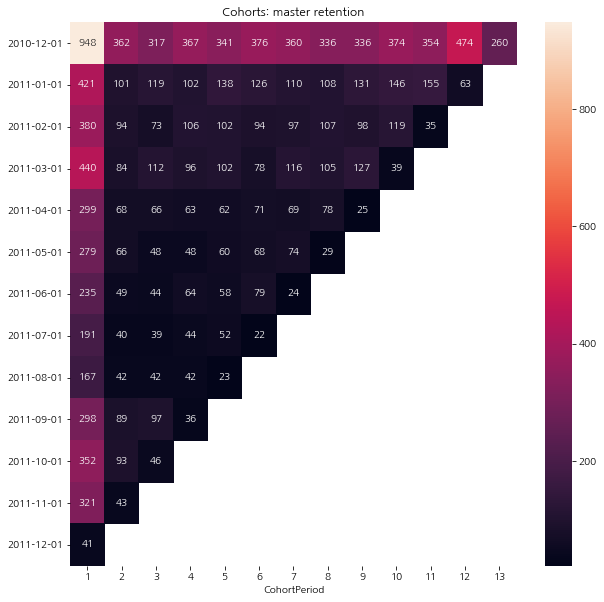

In [51]:
sns_cohort_plot(cohort(df, date_column, id_column,freqdf='MS', normalize=False))